# Градиентный бустинг над деревьями.


Пусть дана обучающая выборка $X = \{(x_i, y_i)\}_{i=1}^N$ и выбран функционал качества 

$$Q(a, X) = \sum_{i=1}^N L(y_i, a(x_i)),$$

который мы стремимся минимизировать. Градиентный бустинг строит композиции вида 

$$a_M(x) = \sum_{j=0}^M \gamma_j b_j(x),$$

где $b_j \in \mathcal{B}$ — базовые алгоритмы из некоторого параметрического семейства $\mathcal{B}$.

Композиция строится пошагово, на $M$-ом шаге к композиции добавляется алгоритм $b_M$ путём выполнения следующих действий:
 1. Вычисление сдвигов текущей композиции по выборке $X$: $$s_i^{(M)} = - \frac{\partial L}{\partial z} (y, z)\Bigg|_{z = a_{M-1}(x_i)}$$
 2. Обучение нового базового алгоритма на выборке $\{(x_i, s_i)\}_{i=1}^N$: $$b_M = \arg\min_{b \in \mathcal{B}} \sum_{i=1}^N (b(x_i) - s_i)^2$$
 3. Подбор коэффициента $\gamma_M$ при новом базовом алгоритме:
 $$\gamma_M = \arg \min_{\gamma} \sum_{i=1}^N L(y_i, a_{M-1}(x_i) + \gamma b_M(x_i))$$
 
В качестве базовых алгоритмов удобно брать решающие деревья малой глубины, поскольку они обладают большим смещением и малым разбросом.





### Сравнение бустинга и бэггинга на модельном примере  

In [216]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

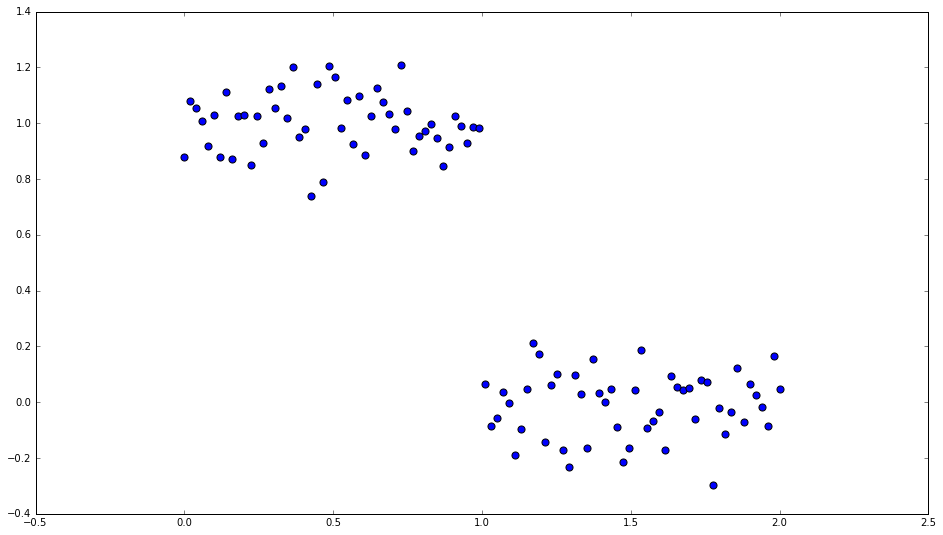

In [217]:
X_train = np.linspace(0, 2, 100)
X_test = np.linspace(0, 2, 1000)

@np.vectorize
def stair(x):
    return x < 1.0

Y_train = stair(X_train) + np.random.randn(*X_train.shape) * 0.1 # пусть целевая функция - ступенька с шумом

plt.figure(figsize = (16, 9))
plt.scatter(X_train, Y_train, s=50)

Обучим на этой выборке большое количество решающих деревьев бэггингом. 

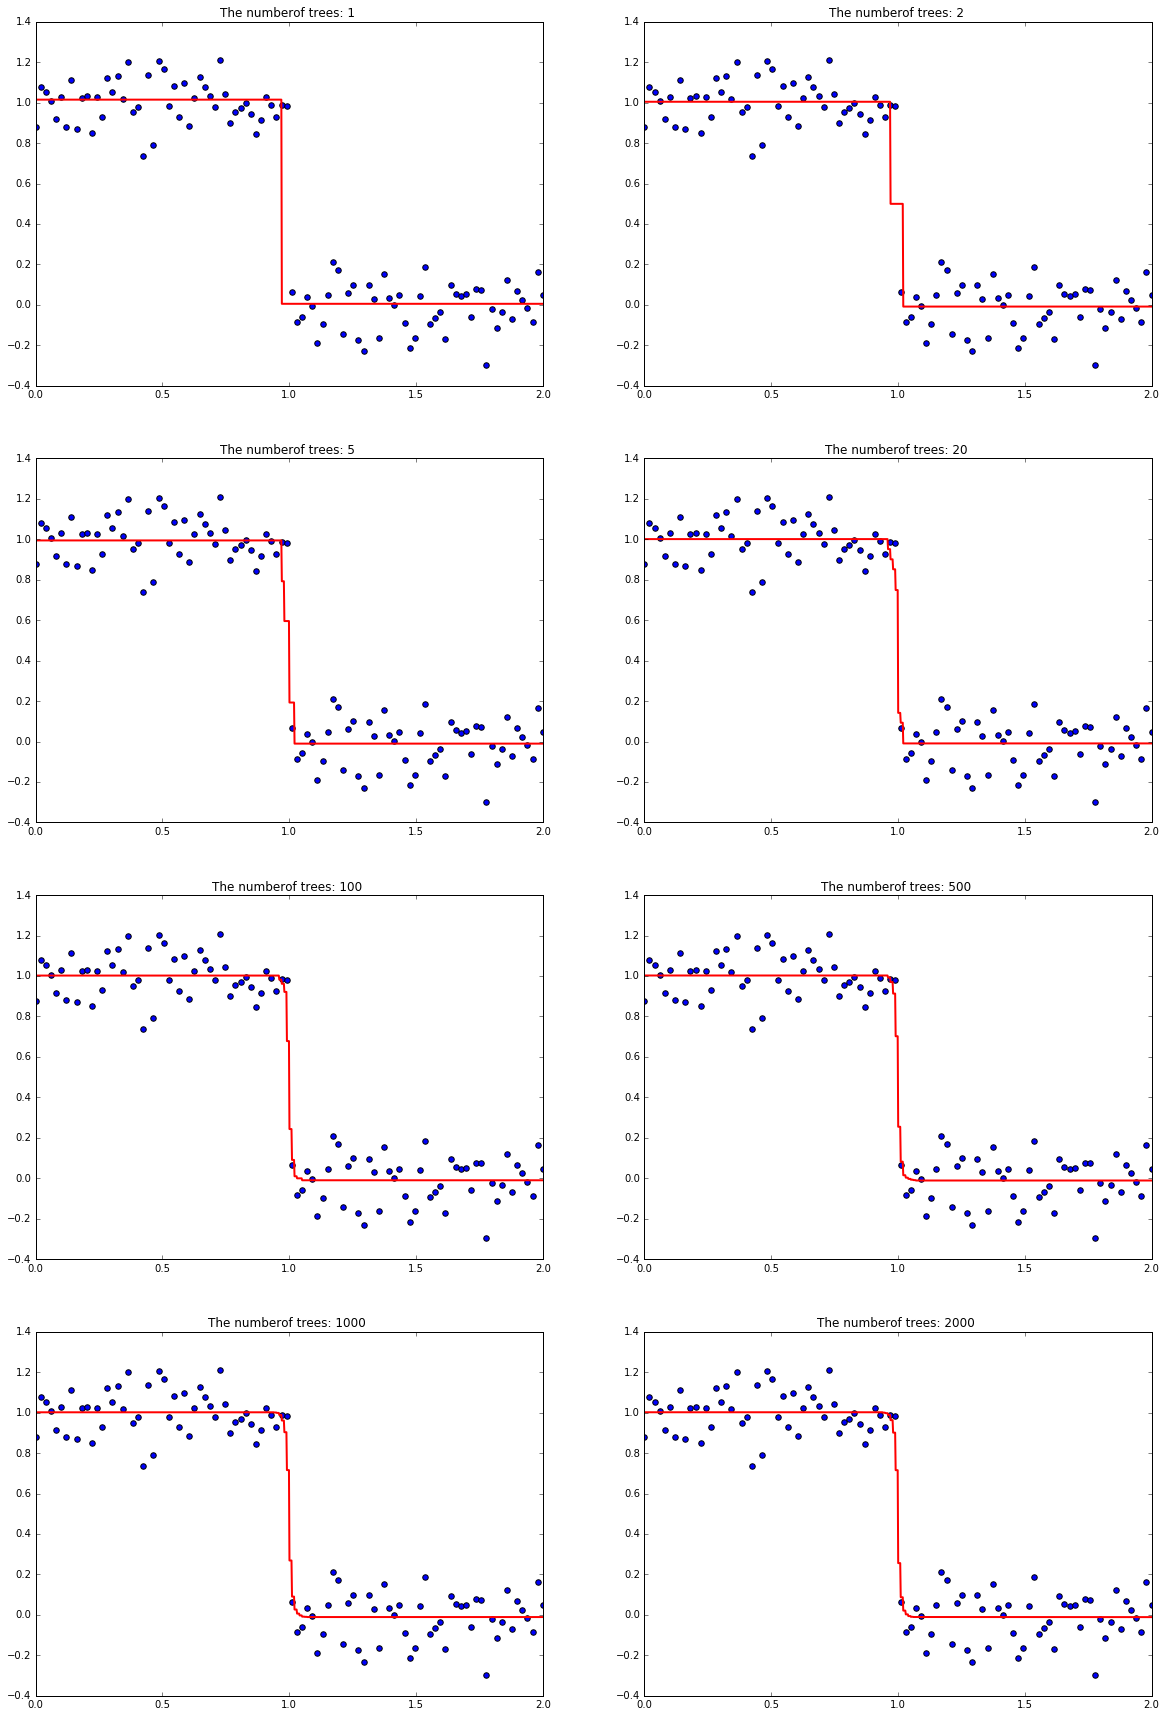

In [218]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor

mod1 = BaggingRegressor(DecisionTreeRegressor(max_depth=1),warm_start=True)
# Обратите внимание на параметр warm_start, при установлении warm_start=True, последующее увеличение числа базовых алгоритмов
#осуществляется посредством добавления новых с уже существующим 
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i in range(len(sizes)):
    mod1.n_estimators = sizes[i]
    mod1.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 2])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, mod1.predict(X_test.reshape(-1, 1)), c='red', linewidth=(2))
    plt.title('The numberof trees: {} '.format(sizes[i]))

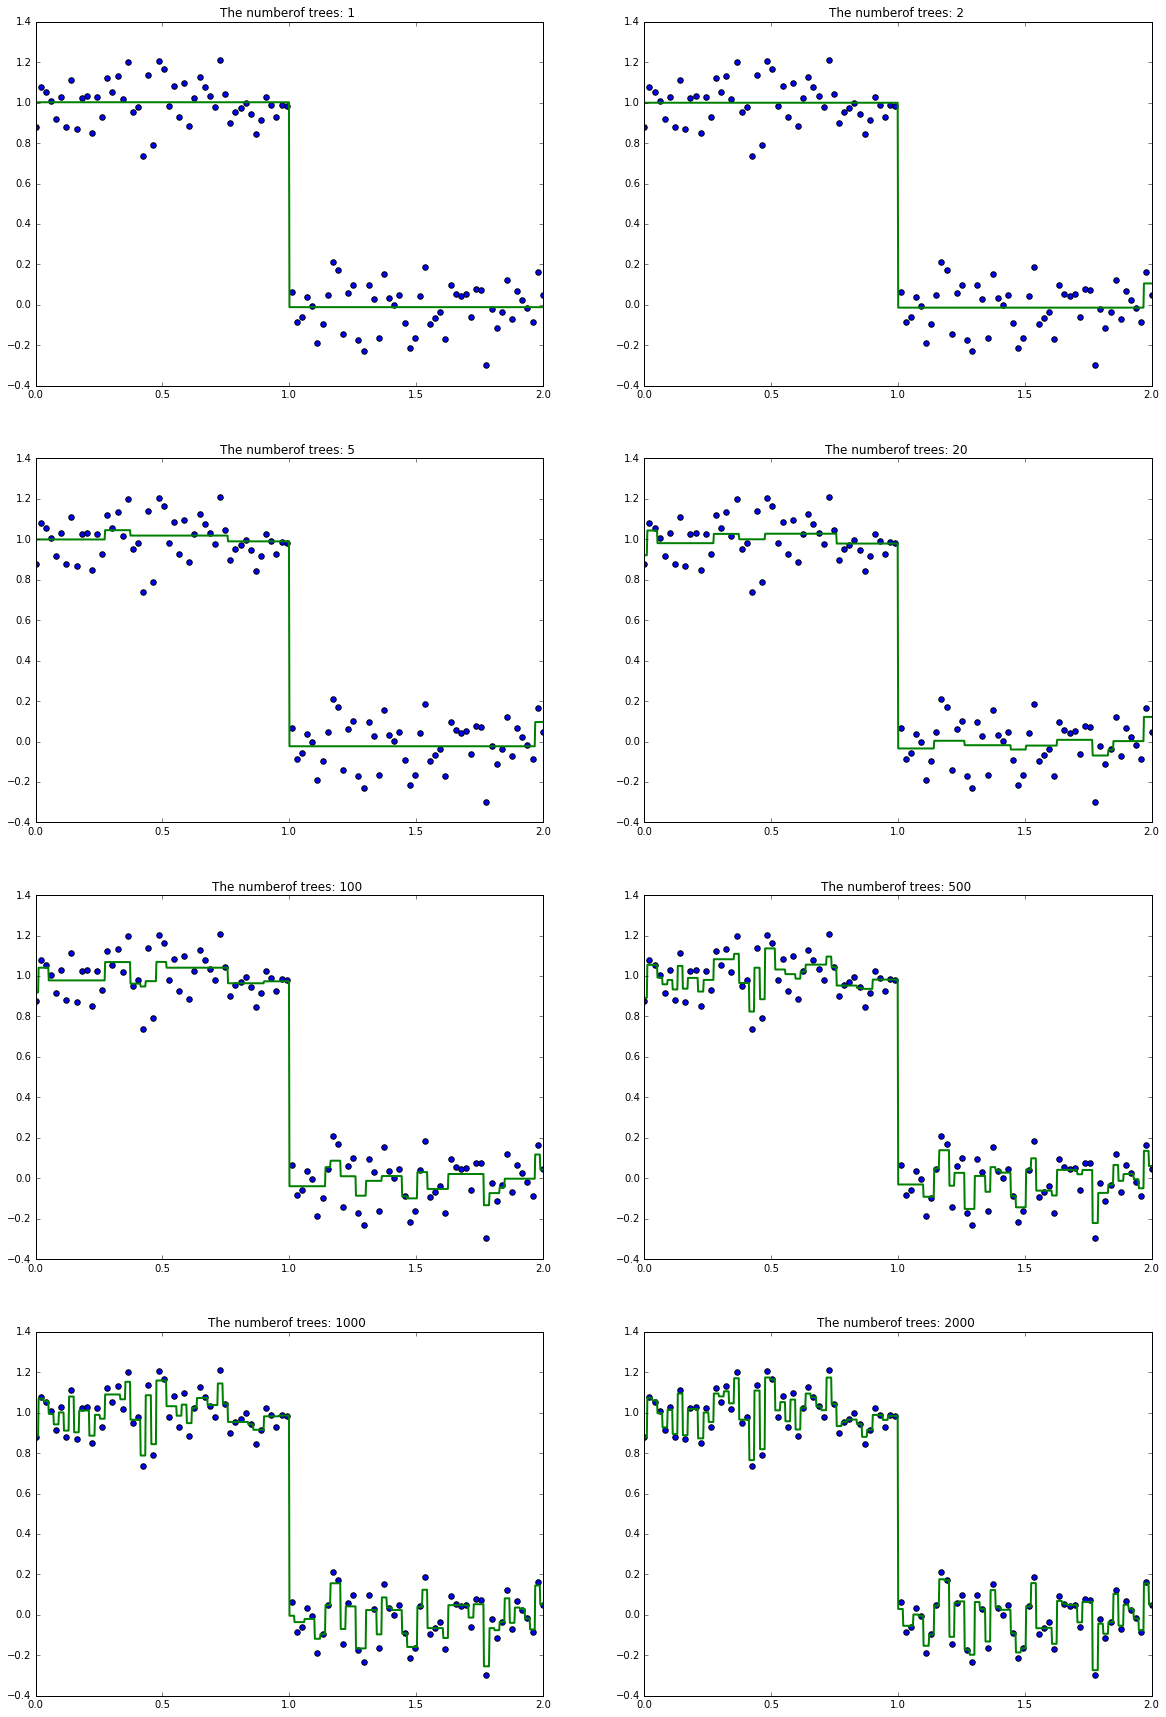

In [219]:
mod2 = GradientBoostingRegressor(max_depth=1, learning_rate=1,warm_start=True)
plt.figure(figsize=(20, 30))
for i in range(len(sizes)):
    mod2.n_estimators = sizes[i]
    mod2.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 2])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, mod2.predict(X_test.reshape(-1, 1)), c='green', linewidth=2)
    plt.title('The numberof trees: {} '.format(sizes[i]))

Градиентный бустинг довольно быстро построил истинную зависимость, после чего начал настраиваться уже на конкретные объекты обучающей выборки, из-за чего сильно переобучился.


Бороться с этой проблемой можно искусственным снижением веса новых алгоритмов при помощи шага $\eta$ (learning_rate):

$$a_M(x) = \sum_{n=0}^M \eta \gamma_M b_M(x).$$


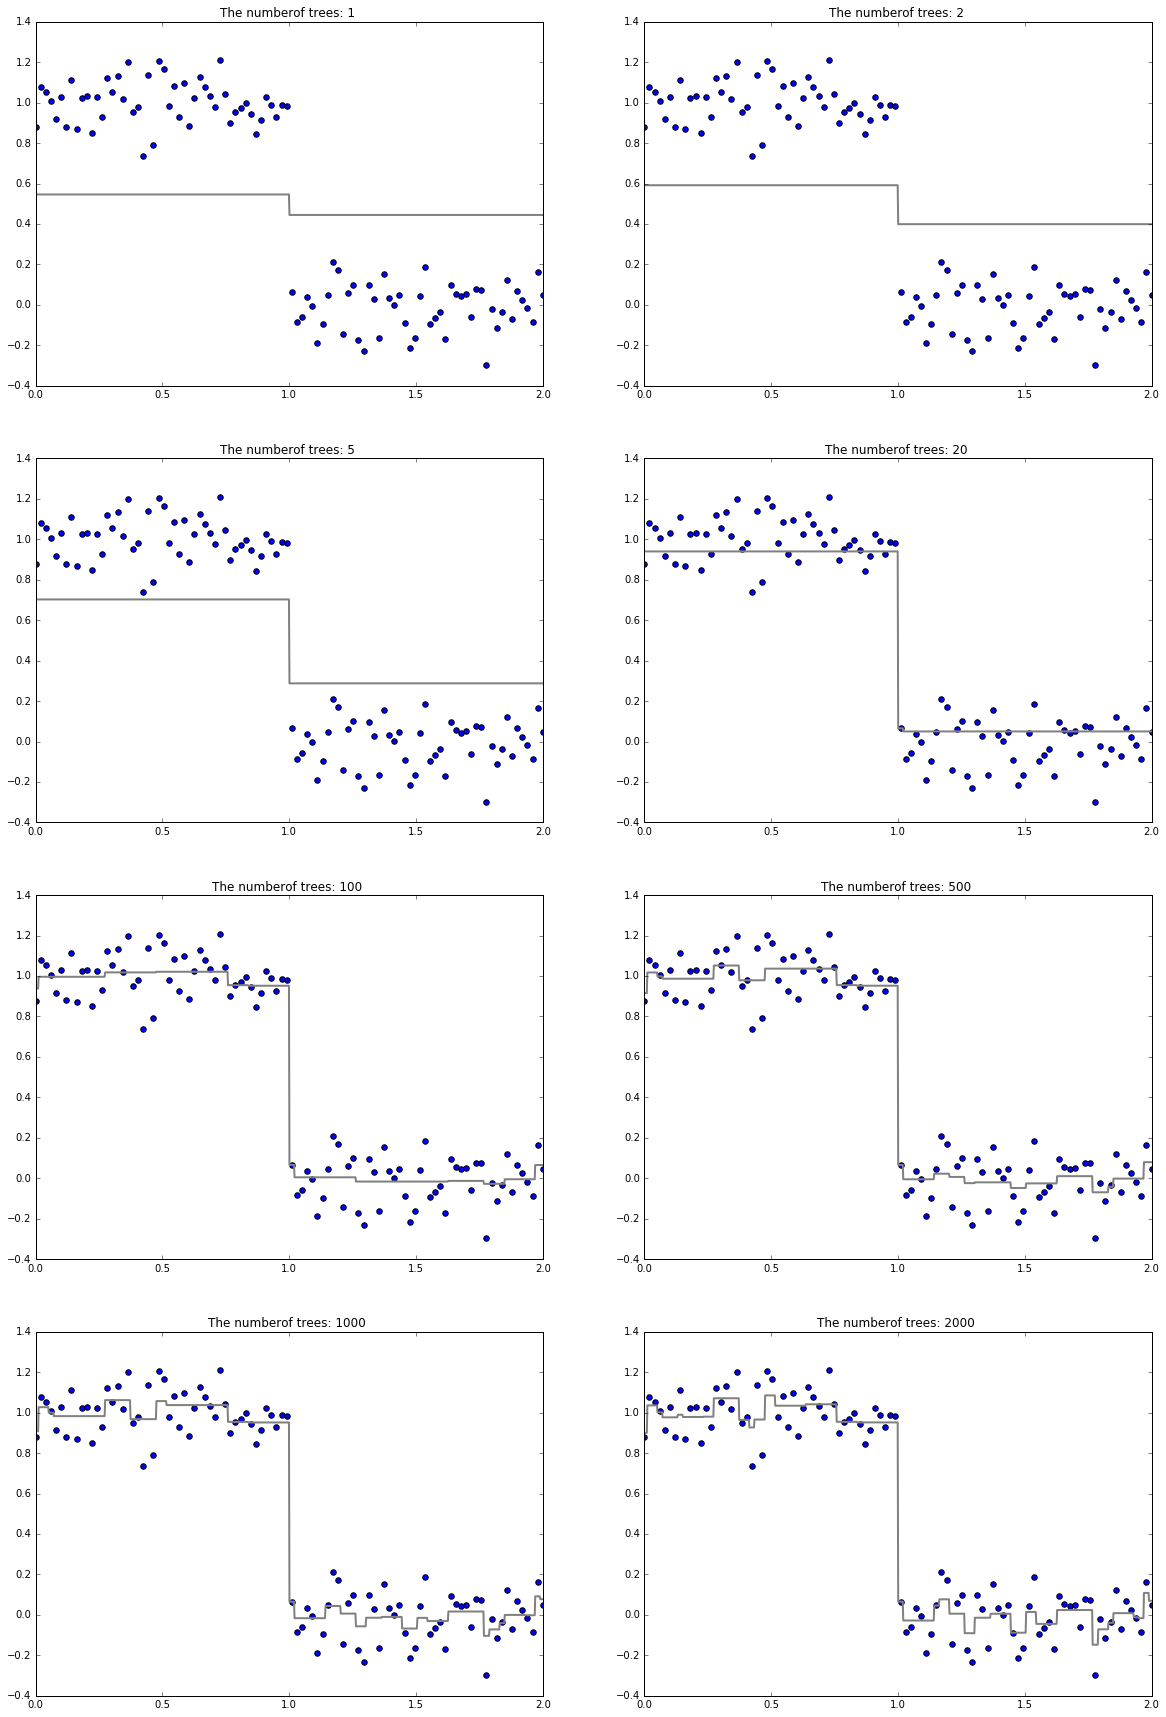

In [220]:
mod3 = GradientBoostingRegressor(max_depth=1, learning_rate=0.1,warm_start=True)
plt.figure(figsize=(20, 30))
for i in range (len(sizes)):
    mod3.n_estimators = sizes[i]
    mod3.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 2])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, mod3.predict(X_test.reshape(-1, 1)), c='gray', linewidth=2)
    plt.title('The numberof trees: {} '.format(sizes[i]))

### Задание 1. 
Сравните с алгоритмом случайного леса

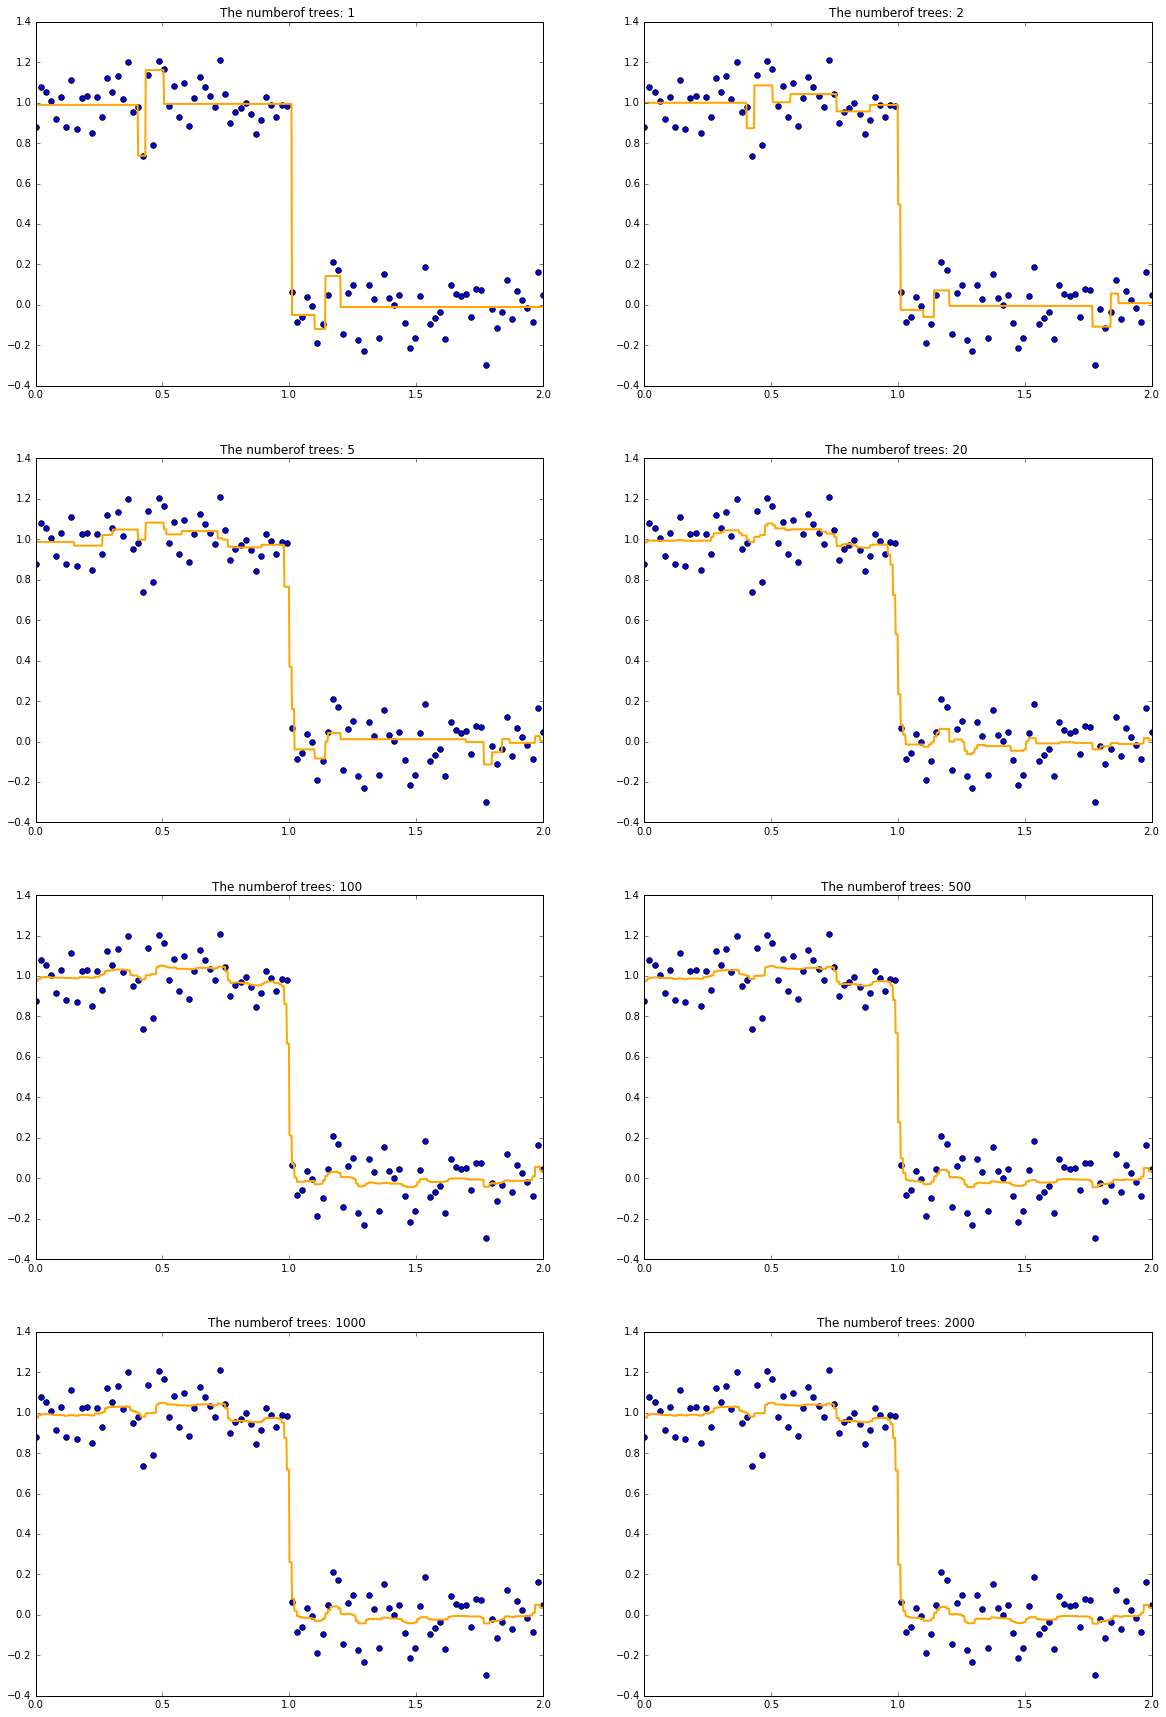

In [221]:
from sklearn.ensemble import RandomForestRegressor
mod4 = RandomForestRegressor(max_depth=3,warm_start=True)
plt.figure(figsize=(20, 30))
for i in range (len(sizes)):
    mod4.n_estimators = sizes[i]
    mod4.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 2])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, mod4.predict(X_test.reshape(-1, 1)), c='orange', linewidth=2)
    plt.title('The numberof trees: {} '.format(sizes[i]))

### Задание 2.



Проверьте полученные выше результаты на реальных данных. Используйте датасет boston, разбейте выборку случайным образом на 406 обучающих объектов и 100 тестовых. Постройте зависимости среднеквадратичного отклонения обучающей и тестовой выборки от числа деревьев (число деревьев до 2000 с шагом 100, используйте warm_start=True) для алгоритмов:

BaggingRegressor 

GradientBoostingRegressor (leaning_rate =1.0)

GradientBoostingRegressor (leaning_rate =0.1)

Random forest

In [222]:
from sklearn.datasets import load_boston
data = load_boston()
#print (data.DESCR)

In [223]:
from sklearn.model_selection import train_test_split

In [224]:
X = data['data']
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 100)

In [225]:
from sklearn.metrics import mean_squared_error as MSE

In [226]:
def mse_on_n_est(reg):
    scores = []
    scores2 = []
    sizes =  np.arange(100,2000,100)
    for i,n in enumerate(sizes):
        reg.n_estimators = n
        pred = reg.fit(X_train, y_train).predict(X_test)
        pred2 = reg.predict(X_train)
        scores.append(MSE(y_test, pred))
        scores2.append(MSE(y_train, pred2))
    plt.figure()
    plt.figure(figsize = (15,5))
    plt.subplot(121)
    plt.plot(sizes,scores,'ro')
    plt.plot(sizes, scores)
    plt.title("Test data")
    plt.subplot(122)
    plt.plot(sizes,scores2,'ro')
    plt.plot(sizes, scores2)
    plt.title("Train data")

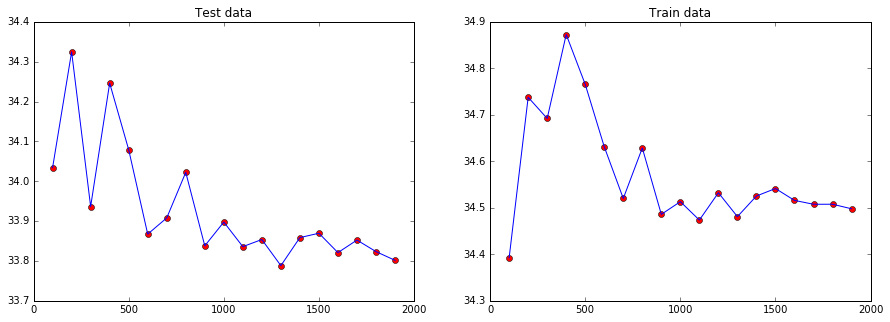

In [227]:
reg = BaggingRegressor(DecisionTreeRegressor(max_depth=1),warm_start=True)
mse_on_n_est(reg)

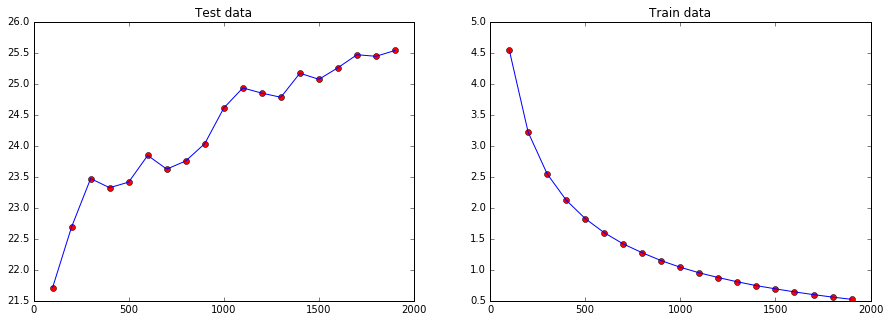

In [228]:
mse_on_n_est(GradientBoostingRegressor(max_depth=1, learning_rate=1,warm_start=True))

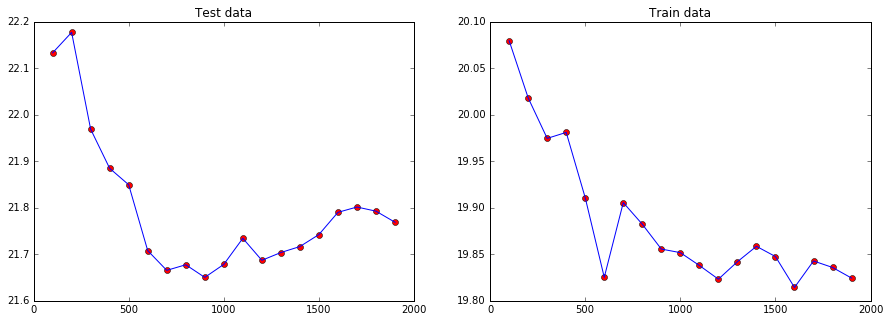

In [229]:
mse_on_n_est(RandomForestRegressor(max_depth=2,warm_start=True))

### Задание 3 Смещение и разброс методов обучения 

Исследуем численно разброс и смещение различных моделей обучения. Данные будем генирировать следующим образом. 
x- одномерное распределение (рассмотрите три различных распределения: нормальное ( np.random.normal(0, 0.3), экспоненциальное (np.random.exponential(0.3)), равномерное (np.random.uniform(0, 1))
y- сумма f(x)=cos(2pi x) и случайного шума (равномерное распределение на [-0.2. 0.2]

Возьмем метод обучения  (рассмотрите 4 различных "LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting") 

1) Обучите модель с параметрами по умолчанию на сгенерированной выборке (число объектов выборки 100). 
Постройте на одном графике объекты выборки и восстановленную регрессионную кривую 


In [230]:
import math
X_norm = np.random.normal(0, 0.3,100)
X_exp = np.random.exponential(0.3,100)
X_unif = np.random.uniform(0, 1,100)
noise = np.random.uniform(-0.2,0.2,100)

In [231]:
y_norm = np.cos(2*np.dot(math.pi,X_norm))+noise
y_exp = np.cos(2*np.dot(math.pi,X_exp))+noise
y_unif = np.cos(2*np.dot(math.pi,X_unif))+noise

In [232]:
from sklearn.linear_model import LinearRegression

In [233]:
mod4 = GradientBoostingRegressor()
mod3 = RandomForestRegressor()
mod2 = DecisionTreeRegressor()
mod1 = LinearRegression()

regressors = [mod1,mod2,mod3,mod4]
names = ['Linear','Decision Tree','Random Forest','Gradient Boosting']

In [234]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

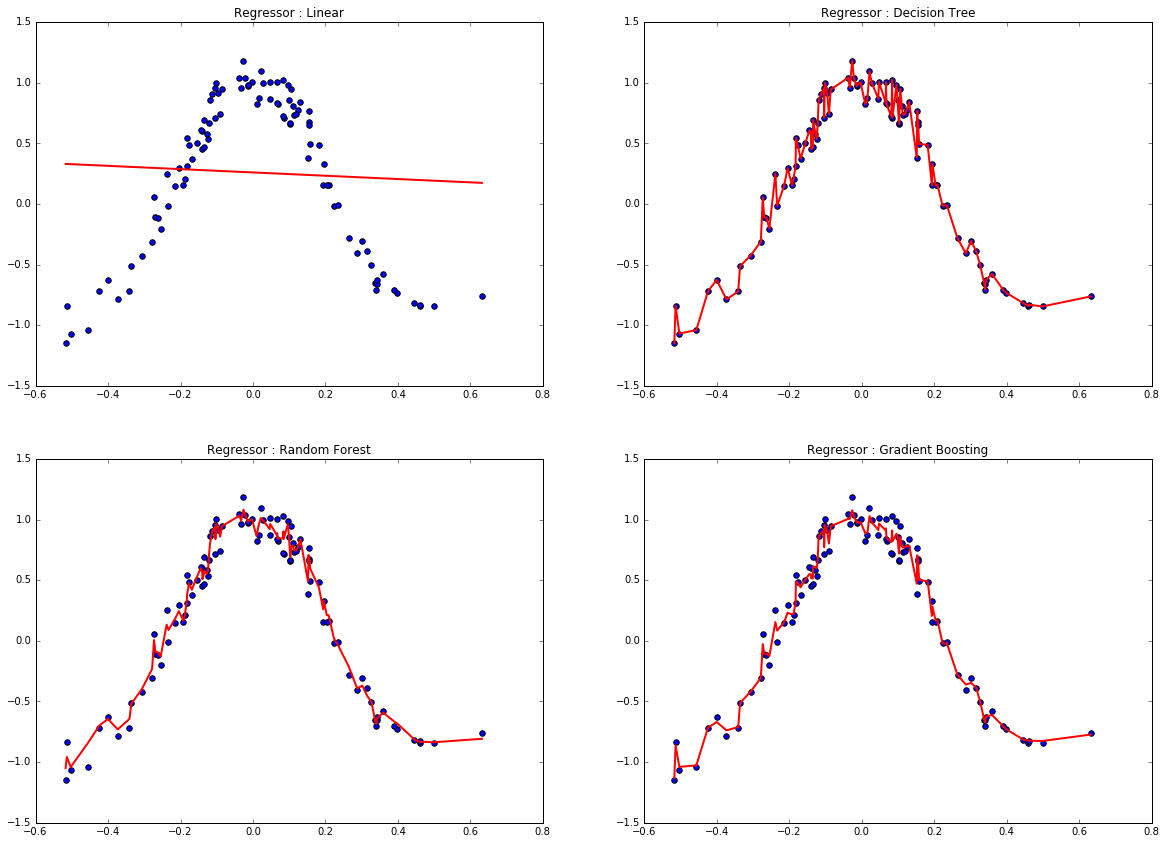

In [235]:
plt.figure(figsize=(20, 30))
plt.title("fgg")
for i,reg in enumerate(regressors):
    reg.fit(X_norm.reshape(-1, 1), y_norm)
    plt.subplot(4, 2, i+1)
    plt.scatter(X_norm, y_norm, s=30)
    X = np.array(sorted(X_norm))
    plt.plot(X, reg.predict(X.reshape(-1, 1)), c='red', linewidth=(2))
    plt.title('Regressor : {}'.format(names[i]))

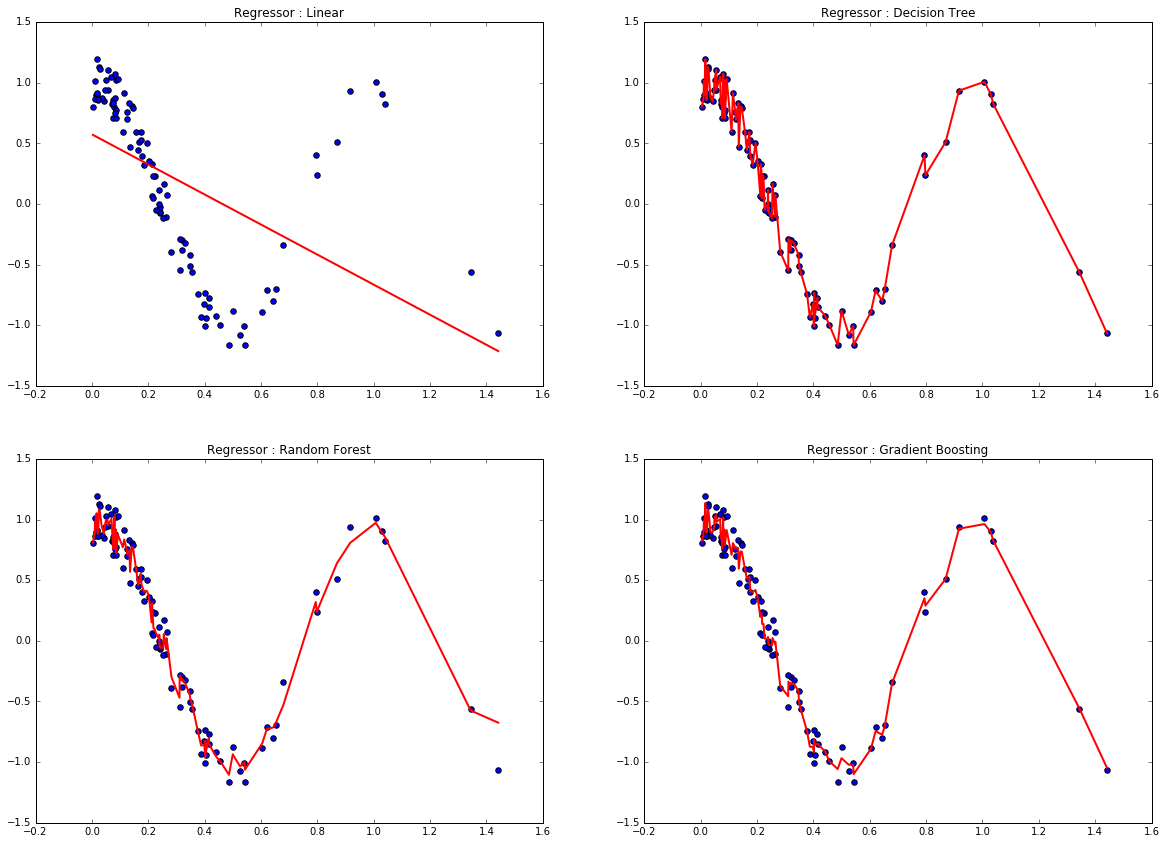

In [236]:
plt.figure(figsize=(20, 30))
for i,reg in enumerate(regressors):
    reg.fit(X_exp.reshape(-1, 1), y_exp)
    plt.subplot(4, 2, i+1)
    plt.scatter(X_exp, y_exp, s=30)
    X = np.array(sorted(X_exp))
    plt.plot(X, reg.predict(X.reshape(-1, 1)), c='red', linewidth=(2))
    plt.title('Regressor : {}'.format(names[i]))

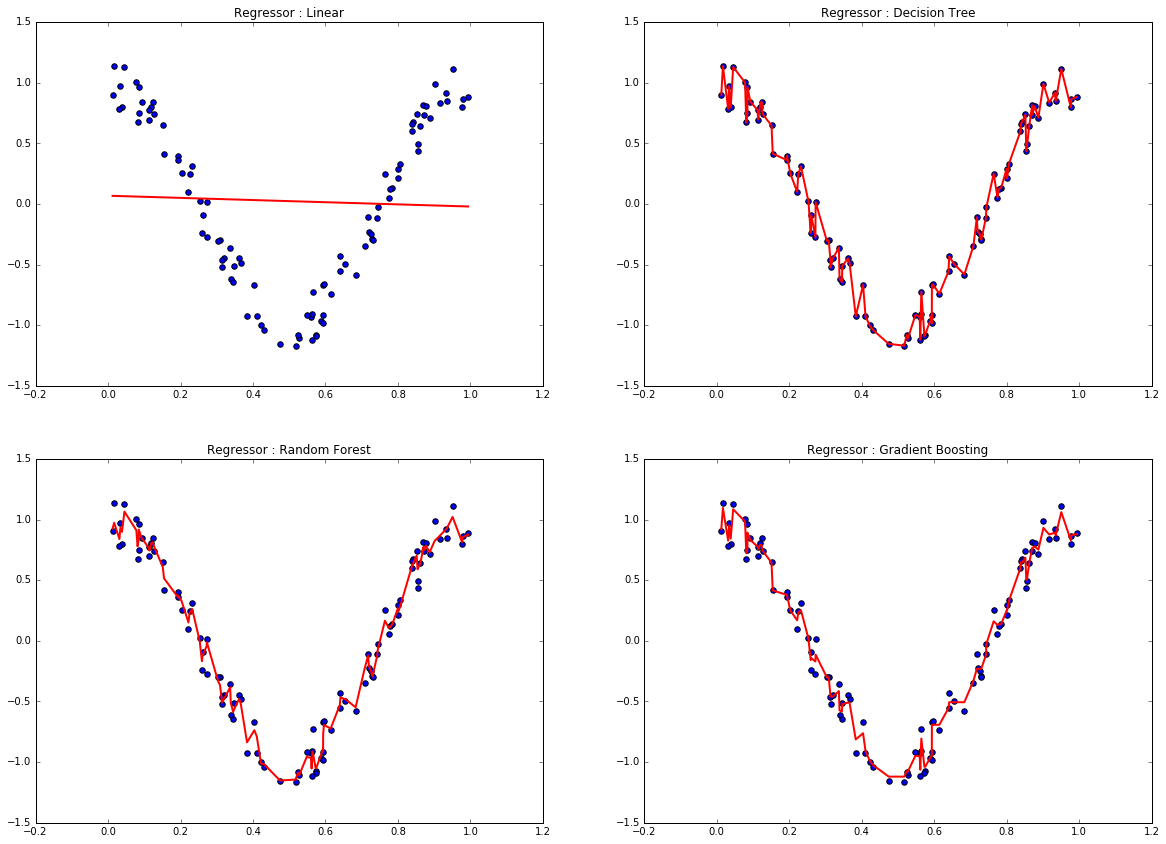

In [237]:
plt.figure(figsize=(20, 30))
for i,reg in enumerate(regressors):
    reg.fit(X_unif.reshape(-1, 1), y_unif)
    plt.subplot(4, 2, i+1)
    plt.scatter(X_unif, y_unif, s=30)
    X = np.array(sorted(X_unif))
    plt.plot(X, reg.predict(X.reshape(-1, 1)), c='red', linewidth=(2))
    plt.title('Regressor : {}'.format(names[i]))


2) Рассмотрим ансамбль обучающих моделей. Сгенерируйте N_samples=25 случайных выборок, обучите и постройте все выборки и все регрессионные кривые на одном графике (полупрозрачным). Посчитайте среднюю кривую F(x) , как среднее арифмитическое по ансамблю регрессионных кривых. Изобразите его тоже на графике. Изобразите истинную кривую ответов.



In [238]:
def plot_norm(model):
    plt.figure(figsize=(10,15))
    res = np.array([0])
    for i in range(25):
        x = np.sort(np.random.normal(0, 0.3, size=100)).reshape(100, 1)
        noise = np.random.uniform(-0.2, 0.2, size=100).reshape(100, 1)
        y = (np.cos(2*np.pi*x) + noise).reshape(100)
        model.fit(x, y)
        plt.subplot(211)
        plt.scatter(x, y, alpha=0.5)
        plt.plot(x, model.predict(x), color='blue', alpha=0.5)
        if res.all() == 0:
            res = model.predict(x)
        else:
            res += model.predict(x)

    plt.plot(np.sort(X_norm), res/25, 'r', linewidth=3)
    res = res/25
    return res

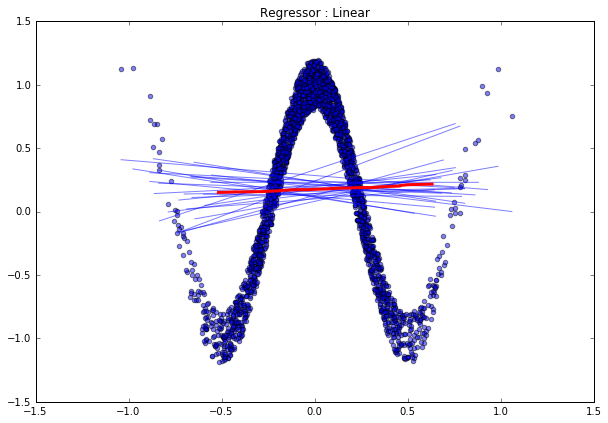

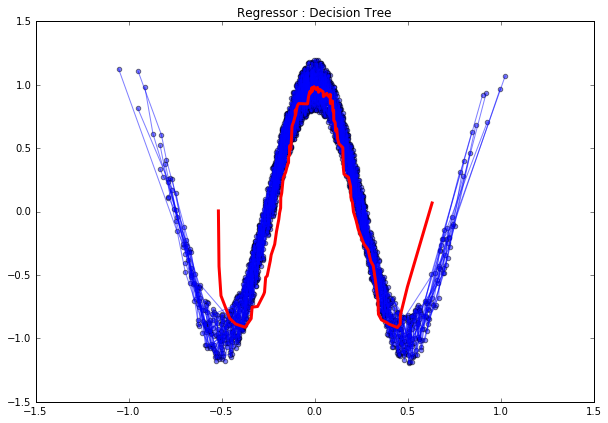

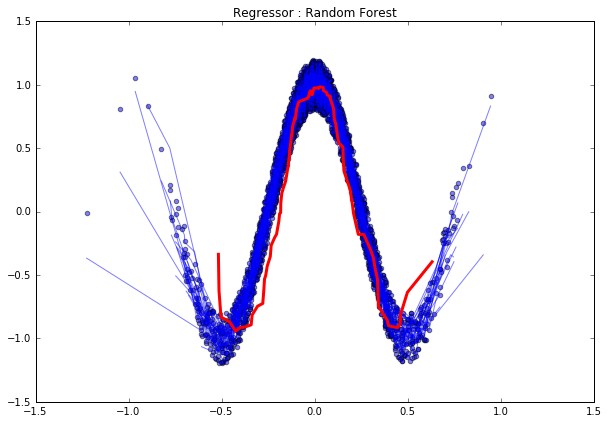

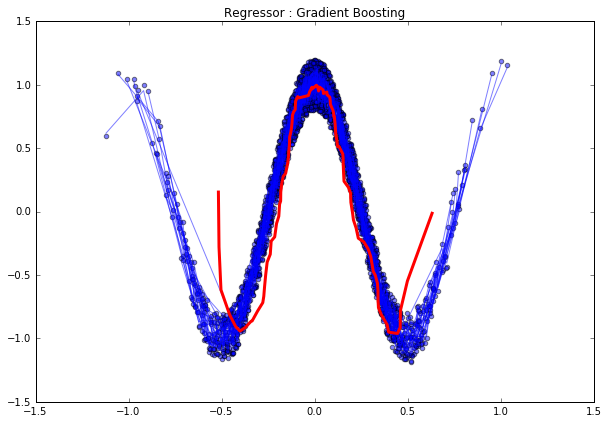

In [239]:
res_norm = []
for i,reg in enumerate(regressors):
    res_norm.append(plot_norm(reg))
    plt.title('Regressor : {}'.format(names[i]))

In [240]:
def plot_exp(model):
    plt.figure(figsize=(10,15))
    res = np.array([0])
    for i in range(25):
        x = np.sort(np.random.exponential(0.3,100)).reshape(100, 1)
        noise = np.random.uniform(-0.2, 0.2, size=100).reshape(100, 1)
        y = (np.cos(2*np.pi*x) + noise).reshape(100)
        model.fit(x, y)
        plt.subplot(211)
        plt.scatter(x, y, alpha=0.5)
        plt.plot(x, model.predict(x), color='blue', alpha=0.5)
        if res.all() == 0:
            res = model.predict(x)
        else:
            res += model.predict(x)

    plt.plot(np.sort(X_exp), res/25, 'r', linewidth=3)
    res = res/25
    return res

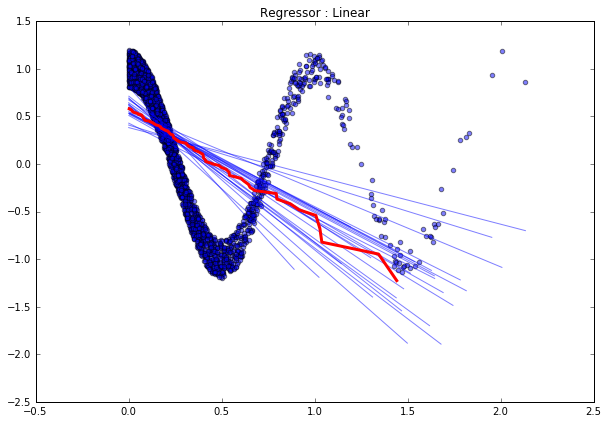

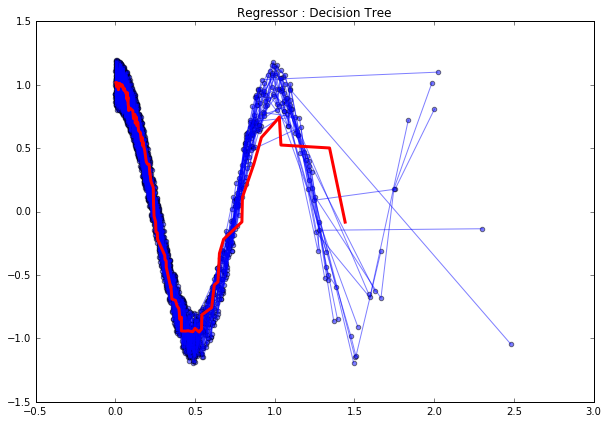

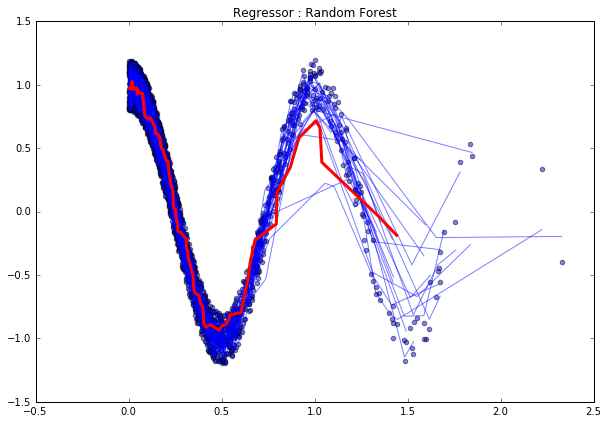

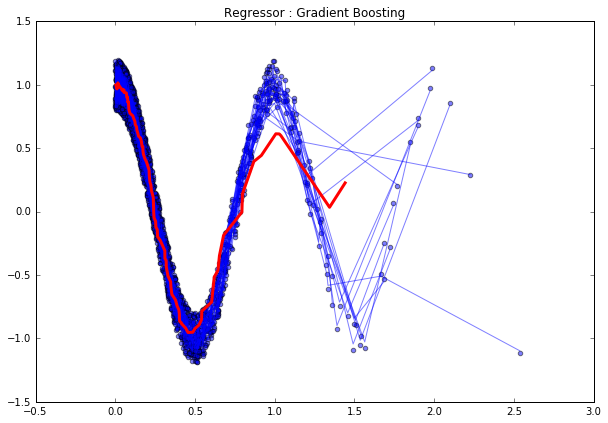

In [241]:
res_exp = []
for i,reg in enumerate(regressors):
    res_exp.append(plot_exp(reg))
    plt.title('Regressor : {}'.format(names[i]))

In [242]:
def plot_unif(model):
    plt.figure(figsize=(10,15))
    res = np.array([0])
    for i in range(25):
        x = np.sort(np.random.uniform(0, 1,100)).reshape(100, 1)
        noise = np.random.uniform(-0.2, 0.2, size=100).reshape(100, 1)
        y = (np.cos(2*np.pi*x) + noise).reshape(100)
        model.fit(x, y)
        plt.subplot(211)
        plt.scatter(x, y, alpha=0.5)
        plt.plot(x, model.predict(x), color='blue', alpha=0.5)
        if res.all() == 0:
            res = model.predict(x)
        else:
            res += model.predict(x)

    plt.plot(np.sort(X_unif), res/25, 'r', linewidth=3)
    res = res/25
    return res

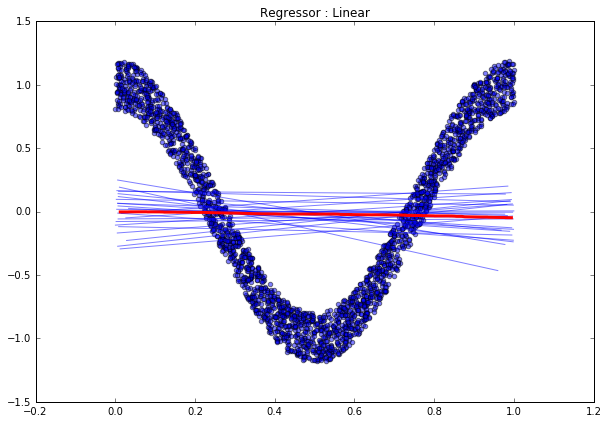

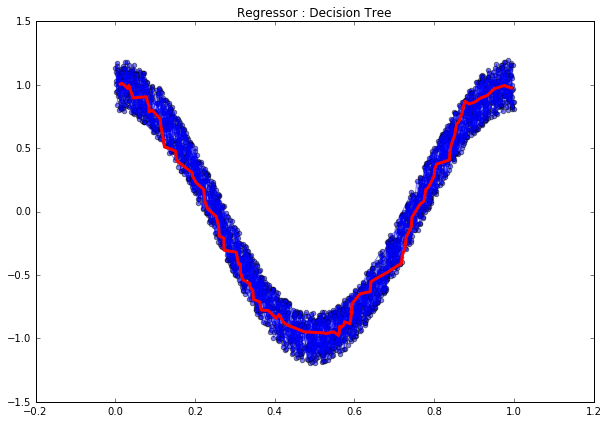

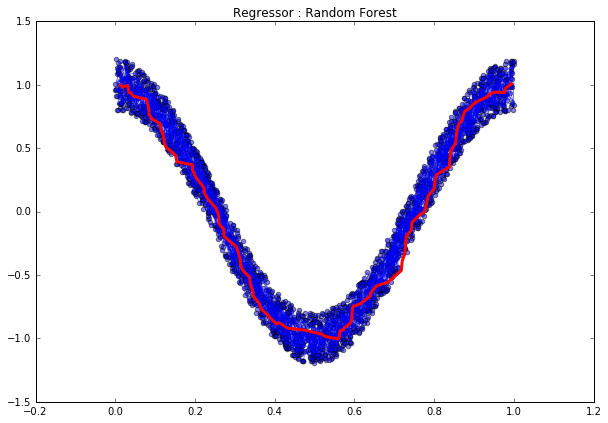

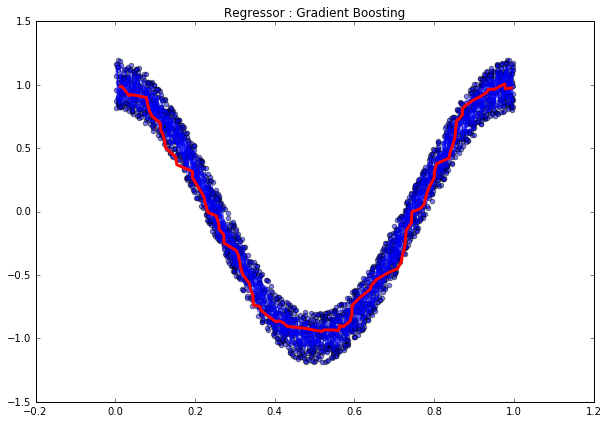

In [243]:
res_unif = []
for i,reg in enumerate(regressors):
    res_unif.append(plot_unif(reg))
    plt.title('Regressor : {}'.format(names[i]))


3) Вычислите смещение метода обучения. Смещение - это среднее квадрата разности вектора зашумленных ответов и вектора предсказаний 

$$ Bias= E_{x,y} ((\mathbb{E}[y|x] - \mathbb{E}_X [\mu(X)])^2)$$. 

Для вычисления этого мат.ожидания будем генерировать выборку размера N_objects=100. Средний ответ $\mathbb{E}[y|x] $ на объекте x вычислите как сумму f(x) + среднее значение шума на выборке N_objects (для этого можно сгенерировать отдельно N_objects шумовых компонент)
Среднее предсказание $\mathbb{E}_X [\mu(X)]$ на объекте x - это значение построенной функции F(x) (см.2)
Мат. ожидание заменяем на среднее арифмитическое по выборке N_objects. 


In [244]:
def bias():
    y_nor_s = np.array([0])
    y_exp_s = np.array([0])
    y_uni_s = np.array([0])
    for i in range(25):
        x_nor_t = np.sort(np.random.normal(0, 0.3, size=100)).reshape(100, 1)
        x_exp_t = np.sort(np.random.exponential(0.3, size=100)).reshape(100, 1)
        x_uni_t = np.sort(np.random.uniform(0, 1, size=100)).reshape(100, 1)
#        noise = np.random.uniform(-0.2, 0.2, size=100).reshape(100, 1)
        y_nor_t = (np.cos(2*np.pi*X_norm) + noise).reshape(100)
        y_exp_t = (np.cos(2*np.pi*X_exp) + noise).reshape(100)
        y_uni_t = (np.cos(2*np.pi*X_unif) + noise).reshape(100)
        
        if y_nor_s.all() == 0:
            y_nor_s = y_nor_t
        else:
            y_nor_s += y_nor_t
        if y_exp_s.all() == 0:
            y_exp_s = y_exp_t
        else:
            y_exp_s += y_exp_t
        if y_uni_s.all() == 0:
            y_uni_s = y_uni_t
        else:
            y_uni_s += y_uni_t
    return y_nor_s/25, y_exp_s/25, y_uni_s/25

# Linear regression

In [245]:
y_nor, y_exp, y_uni = bias()
bias_norm1 = np.mean(((y_nor - res_norm[0])**2))
bias_exp1 = np.mean(((y_exp - res_exp[0])**2))
bias_uni1 = np.mean(((y_uni - res_unif[0])**2))
print("Смещение для нормального распеределения", bias_norm1)
print("Смещение для экспотенциального распеределения", bias_exp1)
print("Смещение для равномерного распеределения", bias_uni1)

Смещение для нормального распеределения 0.438343179597
Смещение для экспотенциального распеределения 0.644823646348
Смещение для равномерного распеределения 0.497914553648


# Decision tree

In [246]:
y_nor, y_exp, y_uni = bias()
bias_norm2 = np.mean(((y_nor - res_norm[1])**2))
bias_exp2 = np.mean(((y_exp - res_exp[1])**2))
bias_uni2 = np.mean(((y_uni - res_unif[1])**2))
print("Смещение для нормального распеределения", bias_norm2)
print("Смещение для экспотенциального распеределения", bias_exp2)
print("Смещение для равномерного распеределения", bias_uni2)

Смещение для нормального распеределения 0.765767601125
Смещение для экспотенциального распеределения 0.990662968326
Смещение для равномерного распеределения 1.08489674137


# Random forest

In [247]:
y_nor, y_exp, y_uni = bias()
bias_norm3 = np.mean(((y_nor - res_norm[2])**2))
bias_exp3 = np.mean(((y_exp - res_exp[2])**2))
bias_uni3 = np.mean(((y_uni - res_unif[2])**2))
print("Смещение для нормального распеределения", bias_norm3)
print("Смещение для экспотенциального распеределения", bias_exp3)
print("Смещение для равномерного распеределения", bias_uni3)

Смещение для нормального распеределения 0.761698018581
Смещение для экспотенциального распеределения 0.948600558814
Смещение для равномерного распеределения 1.07553520249


# Gradient boosting

In [248]:
y_nor, y_exp, y_uni = bias()
bias_norm4 = np.mean(((y_nor - res_norm[3])**2))
bias_exp4 = np.mean(((y_exp - res_exp[3])**2))
bias_uni4 = np.mean(((y_uni - res_unif[3])**2))
print("Смещение для нормального распеределения", bias_norm4)
print("Смещение для экспотенциального распеределения", bias_exp4)
print("Смещение для равномерного распеределения", bias_uni4)

Смещение для нормального распеределения 0.78411296327
Смещение для экспотенциального распеределения 0.954684358446
Смещение для равномерного распеределения 1.08071938627



4) Вычислите разброс метода обучения. Разброс - это среднеквадратичное отклонение предсказания алгоритмов метода $\mu$ на объекте x от среднего предсказания $\mathbb{E}_X [\mu(X)]$
$$ Variance=E_{x,y} (E_{X}(\mathbb{E}_X [\mu(X)] - \mu(X)])^2)$$

Чтобы его вычислить, на выборке N_objects вычислите среднее арифмитическое по N_samples алгоритмам (см. 2) для N_objects объектов.

# Также для каждого алгоритма

In [249]:
var_norm1 = np.var(res_norm[0])
var_exp1 = np.var(res_exp[0])
var_uni1 = np.var(res_unif[0])
print("Разброс для нормального распеределения", var_norm1)
print("Разброс для экспотенциального распеределения", var_exp1)
print("Смещение для равномерного распеределения", var_uni1)

Разброс для нормального распеределения 0.000187032887364
Разброс для экспотенциального распеределения 0.125928523311
Смещение для равномерного распеределения 0.000176548567962


In [250]:
var_norm2 = np.var(res_norm[1])
var_exp2 = np.var(res_exp[1])
var_uni2 = np.var(res_unif[1])
print("Разброс для нормального распеределения", var_norm2)
print("Разброс для экспотенциального распеределения", var_exp2)
print("Смещение для равномерного распеределения", var_uni2)

Разброс для нормального распеределения 0.423442638006
Разброс для экспотенциального распеределения 0.448511108065
Смещение для равномерного распеределения 0.467280231843


In [251]:
var_norm3 = np.var(res_norm[2])
var_exp3 = np.var(res_exp[2])
var_uni3 = np.var(res_unif[2])
print("Разброс для нормального распеределения", var_norm3)
print("Разброс для экспотенциального распеределения", var_exp3)
print("Смещение для равномерного распеределения", var_uni3)

Разброс для нормального распеределения 0.428509193243
Разброс для экспотенциального распеределения 0.428393539898
Смещение для равномерного распеределения 0.46530168734


In [252]:
var_norm4 = np.var(res_norm[3])
var_exp4 = np.var(res_exp[3])
var_uni4 = np.var(res_unif[3])
print("Разброс для нормального распеределения", var_norm4)
print("Разброс для экспотенциального распеределения", var_exp4)
print("Смещение для равномерного распеределения", var_uni4)

Разброс для нормального распеределения 0.429672255766
Разброс для экспотенциального распеределения 0.427263765364
Смещение для равномерного распеределения 0.462464471439


5) Представьте результаты в виде таблицы, проанализируйте (какой метод дает наименьший разброс, какой наименьшее смещение, почему?, как смещение и разброс связаны с распределением признака x)

In [253]:
import pandas as pd

In [254]:
bias_data = [bias_norm1, bias_exp1, bias_uni1, bias_norm2, bias_exp2, bias_uni2, bias_norm3, bias_exp3, bias_uni3, bias_norm4, bias_exp4, bias_uni4]
var_data = [var_norm1, var_exp1, var_uni1,var_norm2, var_exp2, var_uni2,var_norm3, var_exp3, var_uni3, var_norm4, var_exp4, var_uni4]

In [255]:
bias = pd.DataFrame(np.reshape(bias_data, (4,3)), columns=["normal(0, 0.3)", "exponential(0.3)", "uniform(0, 1)"],
                      index=["LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting"])
variance = pd.DataFrame(np.reshape(var_data, (4,3)), columns=bias.columns, index=bias.index)

In [256]:
bias

,"normal(0, 0.3)",exponential(0.3),"uniform(0, 1)"
LinearRegression,0.438343,0.644824,0.497915
DecisionTree,0.765768,0.990663,1.084897
RandomForest,0.761698,0.948601,1.075535
GradientBoosting,0.784113,0.954684,1.080719


In [257]:
variance

,"normal(0, 0.3)",exponential(0.3),"uniform(0, 1)"
LinearRegression,0.000187,0.125929,0.000177
DecisionTree,0.423443,0.448511,0.467280
RandomForest,0.428509,0.428394,0.465302
GradientBoosting,0.429672,0.427264,0.462464


### Задание 4 Наивный байесовский классификатор

Пусть дана выборка (x1,x2,y):
(1,1,0); (0,1,0); (0,1,0); (0,1,0); (1,0,0);

(0,0,1); (1,0,1); (1,0,1); (1,0,1); (0,0,1)

С помощью наивного байесова классификатора оценить апостериорные вероятности Pr(y |x), если (a) x1 = 1,
x2 = 0; (b) x1 = 0, x2 = 1

In [258]:
X = [[1,1],[0,1],[0,1],[0,1],[1,0],[0,0],[1,0],[1,0],[1,0],[0,0]]

In [259]:
y = [0,0,0,0,0,1,1,1,1,1]

In [260]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X,y)

In [261]:
print(gnb.predict([1,0]))
print(gnb.predict_proba([1,0]))

[1]
[[  3.52665913e-06   9.99996473e-01]]


C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [262]:
print(gnb.predict([1,1]))
print(gnb.predict_proba([1,1]))

[0]
[[ 1.  0.]]


C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
